# Modelling Intrusion Detection: Analysis of a Feature Selection Mechanism

## Method Description

### Step 1: Data preprocessing:
All features are made numerical using one-Hot-encoding. The features are scaled to avoid features with large values that may weigh too much in the results.

### Step 2: Feature Selection:
Eliminate redundant and irrelevant data by selecting a subset of relevant features that fully represents the given problem.
Univariate feature selection with ANOVA F-test. This analyzes each feature individually to detemine the strength of the relationship between the feature and labels. Using SecondPercentile method (sklearn.feature_selection) to select features based on percentile of the highest scores. 
When this subset is found: Recursive Feature Elimination (RFE) is applied.

### Step 4: Build the model:
Decision tree model is built.

### Step 5: Prediction & Evaluation (validation):
Using the test data to make predictions of the model.
Multiple scores are considered such as:accuracy score, recall, f-measure, confusion matrix.
perform a 10-fold cross-validation.

## Version Check

In [1]:
import pandas as pd
import numpy as np
import sys
import sklearn
print(pd.__version__)
print(np.__version__)
print(sys.version)
print(sklearn.__version__)

1.2.5
1.21.0
3.9.5 (tags/v3.9.5:0a7dcbd, May  3 2021, 17:27:52) [MSC v.1928 64 bit (AMD64)]
0.24.2


## Creating Datasets

In [2]:
# loading every parts and concat them
files = ["Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv", "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
         "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
         "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv"]

#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in files])

# drop entries with NaN values
combined_csv.dropna(inplace=True)

# drop entriers with values greater than max float
for col in combined_csv.columns: 
        if(col == " Label") : print("Ignored column Label")
        
        else : combined_csv = combined_csv.loc[(combined_csv[col] < np.finfo(np.float64).max )]

# shuffle data
combined_csv = combined_csv.sample(frac=1).reset_index(drop=True)

# slice into train and test data sets
chunk = int (combined_csv.shape[0]*75/100)  #ratio = 75 %  /  25% 
train_set =combined_csv.iloc[:chunk,:]
test_set = combined_csv.iloc[chunk:,:]

# exporting data sets
train_set.to_csv("train_IDS2017.csv", index=False)
test_set.to_csv("test_IDS2017.csv", index=False)

Ignorer colonne Label


## Load the Dataset

In [11]:
# train_IDS2017 & test_IDS2017 are the datafiles
df = pd.read_csv("train_IDS2017.csv")
df_test = pd.read_csv("test_IDS2017.csv")

# shape, this gives the dimensions of the dataset
print('Dimensions of the Training set:',df.shape)
print('Dimensions of the Test set:',df_test.shape)

Dimensions of the Training set: (727824, 79)
Dimensions of the Test set: (242609, 79)


## Sample view of the training dataset

In [4]:
# first five rows
df.head(5)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,50683,224,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,80,1806933,3,5,26,11601,20,0,8.666667,10.263203,...,20,0.0,0.0,0,0,0.0,0.0,0,0,DDoS
2,1072,4,2,0,4,0,2,2,2.000000,0.000000,...,24,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,1025,52,1,1,0,6,0,0,0.000000,0.000000,...,40,0.0,0.0,0,0,0.0,0.0,0,0,PortScan
4,53,198,2,2,74,154,37,37,37.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


## Statistical Summary

In [5]:
df.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,727824.000000,7.278240e+05,727824.000000,727824.000000,7.278240e+05,7.278240e+05,727824.000000,727824.000000,727824.000000,727824.000000,...,727824.000000,727824.000000,7.278240e+05,7.278240e+05,7.278240e+05,7.278240e+05,7.278240e+05,7.278240e+05,7.278240e+05,7.278240e+05
mean,8242.451931,1.020092e+07,6.594912,7.016518,5.530315e+02,9.481931e+03,220.814928,18.603322,66.390255,77.808326,...,4.331161,25.697632,8.450778e+04,3.058639e+04,1.399384e+05,6.785821e+04,4.287578e+06,9.145526e+05,4.936620e+06,3.609885e+06
std,17596.207516,2.815826e+07,463.457666,613.345762,1.615983e+04,1.450223e+06,983.231186,83.273512,264.614806,409.158199,...,444.200488,6.911027,6.025585e+05,3.246402e+05,8.916254e+05,5.554432e+05,1.442221e+07,6.459052e+06,1.666188e+07,1.342620e+07
min,0.000000,-1.200000e+01,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,53.000000,6.400000e+01,1.000000,1.000000,4.000000e+00,6.000000e+00,2.000000,0.000000,2.000000,0.000000,...,0.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,123.000000,2.380600e+04,2.000000,2.000000,3.000000e+01,4.800000e+01,20.000000,2.000000,8.666667,0.000000,...,1.000000,24.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,3372.000000,1.187100e+06,4.000000,3.000000,8.400000e+01,2.860000e+02,46.000000,32.000000,43.000000,5.656854,...,2.000000,32.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,65532.000000,1.200000e+08,200755.000000,270686.000000,1.290000e+07,6.270000e+08,23360.000000,2065.000000,4183.057143,6692.644993,...,192491.000000,60.000000,1.100000e+08,7.050000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.530000e+07,1.200000e+08,1.200000e+08


## Label Distribution of Training and Test set

In [18]:
print('Label distribution Training set:')
print(df[' Label'].value_counts())
print()
print('Label distribution Test set:')
print(df_test[' Label'].value_counts())

Label distribution Training set:
0    511084
2    119059
1     96023
3      1631
4        27
Name:  Label, dtype: int64

Label distribution Test set:
0    170304
2     39745
1     32002
3       549
4         9
Name:  Label, dtype: int64


# Step 1: Data preprocessing:

# Split Dataset into 4 datasets for every attack category
## Rename every attack label: 0=normal, 1=DoS, 2=Probe, 3=Web and 4=Infil.
## Replace labels column with new labels column
## Make new datasets


In [21]:
# take label column
labeldf=df[' Label']
labeldf_test=df_test[' Label']
# change the label column
newlabeldf=labeldf.replace({ 'BENIGN' : 0, 'DDoS' : 1, 'PortScan' : 2, 'Web Attack � Brute Force': 3,
                            'Web Attack � XSS': 3, 'Web Attack � Sql Injection': 3,
                            'Infiltration': 4})
newlabeldf_test=labeldf_test.replace({ 'BENIGN' : 0, 'DDoS' : 1, 'PortScan' : 2, 'Web Attack � Brute Force': 3,
                            'Web Attack � XSS': 3, 'Web Attack � Sql Injection': 3,
                            'Infiltration': 4})
# put the new label column back
df[' Label'] = newlabeldf
df_test[' Label'] = newlabeldf_test
print(df[' Label'].head())

0    0
1    1
2    0
3    2
4    0
Name:  Label, dtype: int64


In [22]:
to_drop_DoS = [2,3,4]
to_drop_Probe = [1,3,4]
to_drop_Web = [1,2,4]
to_drop_Infil = [1,2,3]
DoS_df=df[~df[' Label'].isin(to_drop_DoS)];
Probe_df=df[~df[' Label'].isin(to_drop_Probe)];
Web_df=df[~df[' Label'].isin(to_drop_Web)];
Infil_df=df[~df[' Label'].isin(to_drop_Infil)];

#test
DoS_df_test=df_test[~df_test[' Label'].isin(to_drop_DoS)];
Probe_df_test=df_test[~df_test[' Label'].isin(to_drop_Probe)];
Web_df_test=df_test[~df_test[' Label'].isin(to_drop_Web)];
Infil_df_test=df_test[~df_test[' Label'].isin(to_drop_Infil)];
print('Train:')
print('Dimensions of DoS:' ,DoS_df.shape)
print('Dimensions of Probe:' ,Probe_df.shape)
print('Dimensions of Web:' ,Web_df.shape)
print('Dimensions of Infil:' ,Infil_df.shape)
print('Test:')
print('Dimensions of DoS:' ,DoS_df_test.shape)
print('Dimensions of Probe:' ,Probe_df_test.shape)
print('Dimensions of Web:' ,Web_df_test.shape)
print('Dimensions of Infil:' ,Infil_df_test.shape)

Train:
Dimensions of DoS: (607107, 79)
Dimensions of Probe: (630143, 79)
Dimensions of Web: (512715, 79)
Dimensions of Infil: (511111, 79)
Test:
Dimensions of DoS: (202306, 79)
Dimensions of Probe: (210049, 79)
Dimensions of Web: (170853, 79)
Dimensions of Infil: (170313, 79)


# Step 2: Feature Scaling:

In [25]:
# Split dataframes into X & Y
# assign X as a dataframe of feautures and Y as a series of outcome variables
X_DoS = DoS_df.drop(' Label',1)
Y_DoS = DoS_df[' Label']
X_Probe = Probe_df.drop(' Label',1)
Y_Probe = Probe_df[' Label']
X_Web = Web_df.drop(' Label',1)
Y_Web = Web_df[' Label']
X_Infil = Infil_df.drop(' Label',1)
Y_Infil = Infil_df[' Label']
# test set
X_DoS_test = DoS_df_test.drop(' Label',1)
Y_DoS_test = DoS_df_test[' Label']
X_Probe_test = Probe_df_test.drop(' Label',1)
Y_Probe_test = Probe_df_test[' Label']
X_Web_test = Web_df_test.drop(' Label',1)
Y_Web_test = Web_df_test[' Label']
X_Infil_test = Infil_df_test.drop(' Label',1)
Y_Infil_test = Infil_df_test[' Label']

### Save a list of feature names for later use (it is the same for every attack category). Column names are dropped at this stage.

In [26]:
colNames=list(X_DoS)
colNames_test=list(X_DoS_test)

## Use StandardScaler() to scale the dataframes

In [27]:
from sklearn import preprocessing
scaler1 = preprocessing.StandardScaler().fit(X_DoS)
X_DoS=scaler1.transform(X_DoS) 
scaler2 = preprocessing.StandardScaler().fit(X_Probe)
X_Probe=scaler2.transform(X_Probe) 
scaler3 = preprocessing.StandardScaler().fit(X_Web)
X_Web=scaler3.transform(X_Web) 
scaler4 = preprocessing.StandardScaler().fit(X_Infil)
X_Infil=scaler4.transform(X_Infil) 
# test data
scaler5 = preprocessing.StandardScaler().fit(X_DoS_test)
X_DoS_test=scaler5.transform(X_DoS_test) 
scaler6 = preprocessing.StandardScaler().fit(X_Probe_test)
X_Probe_test=scaler6.transform(X_Probe_test) 
scaler7 = preprocessing.StandardScaler().fit(X_Web_test)
X_Web_test=scaler7.transform(X_Web_test) 
scaler8 = preprocessing.StandardScaler().fit(X_Infil_test)
X_Infil_test=scaler8.transform(X_Infil_test) 

### Check that the Standard Deviation is 1

In [28]:
print(X_DoS.std(axis=0))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [29]:
X_Probe.std(axis=0);
X_Web.std(axis=0);
X_Infil.std(axis=0);

# Step 3: Feature Selection:

# 1. Univariate Feature Selection using ANOVA F-test

In [30]:
#univariate feature selection with ANOVA F-test. using secondPercentile method, then RFE
#Scikit-learn exposes feature selection routines as objects that implement the transform method
#SelectPercentile: removes all but a user-specified highest scoring percentage of features
#f_classif: ANOVA F-value between label/feature for classification tasks.
from sklearn.feature_selection import SelectPercentile, f_classif
np.seterr(divide='ignore', invalid='ignore');
selector=SelectPercentile(f_classif, percentile=10)
X_newDoS = selector.fit_transform(X_DoS,Y_DoS)
X_newDoS.shape

C:\Users\Mathis\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [31 33 56 57 58 59 60 61] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,


(607107, 8)

### Get the features that were selected: DoS

In [31]:
true=selector.get_support()
newcolindex_DoS=[i for i, x in enumerate(true) if x]
newcolname_DoS=list( colNames[i] for i in newcolindex_DoS )
newcolname_DoS

['Bwd Packet Length Max',
 ' Bwd Packet Length Mean',
 ' Bwd Packet Length Std',
 ' Max Packet Length',
 ' Packet Length Mean',
 ' Packet Length Std',
 ' Average Packet Size',
 ' Avg Bwd Segment Size']

In [32]:
X_newProbe = selector.fit_transform(X_Probe,Y_Probe)
X_newProbe.shape

C:\Users\Mathis\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [31 33 56 57 58 59 60 61] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,


(630143, 8)

### Get the features that were selected: Probe

In [33]:
true=selector.get_support()
newcolindex_Probe=[i for i, x in enumerate(true) if x]
newcolname_Probe=list( colNames[i] for i in newcolindex_Probe )
newcolname_Probe

[' Bwd Packet Length Min',
 ' Min Packet Length',
 ' Packet Length Mean',
 ' PSH Flag Count',
 ' ACK Flag Count',
 ' Average Packet Size',
 'Init_Win_bytes_forward',
 ' min_seg_size_forward']

In [34]:
X_newWeb = selector.fit_transform(X_Web,Y_Web)
X_newWeb.shape

C:\Users\Mathis\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [31 33 56 57 58 59 60 61] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,


(512715, 8)

### Get the features that were selected: R2L

In [35]:
true=selector.get_support()
newcolindex_Web=[i for i, x in enumerate(true) if x]
newcolname_Web=list( colNames[i] for i in newcolindex_Web)
newcolname_Web

[' Destination Port',
 ' Bwd Packet Length Min',
 ' Min Packet Length',
 ' PSH Flag Count',
 ' Down/Up Ratio',
 'Init_Win_bytes_forward',
 ' Init_Win_bytes_backward',
 ' min_seg_size_forward']

In [36]:
X_newInfil = selector.fit_transform(X_Infil,Y_Infil)
X_newInfil.shape

C:\Users\Mathis\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [31 33 56 57 58 59 60 61] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,


(511111, 8)

### Get the features that were selected: U2R

In [37]:
true=selector.get_support()
newcolindex_Infil=[i for i, x in enumerate(true) if x]
newcolname_Infil=list( colNames[i] for i in newcolindex_Infil)
newcolname_Infil

['Total Length of Fwd Packets',
 'Fwd PSH Flags',
 ' SYN Flag Count',
 ' Subflow Fwd Bytes',
 'Active Mean',
 ' Active Std',
 ' Active Max',
 ' Active Min']

# Summary of features selected by Univariate Feature Selection

In [38]:
print('Features selected for DoS:',newcolname_DoS)
print()
print('Features selected for Probe:',newcolname_Probe)
print()
print('Features selected for R2L:',newcolname_Web)
print()
print('Features selected for U2R:',newcolname_Infil)

Features selected for DoS: ['Bwd Packet Length Max', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Average Packet Size', ' Avg Bwd Segment Size']

Features selected for Probe: [' Bwd Packet Length Min', ' Min Packet Length', ' Packet Length Mean', ' PSH Flag Count', ' ACK Flag Count', ' Average Packet Size', 'Init_Win_bytes_forward', ' min_seg_size_forward']

Features selected for R2L: [' Destination Port', ' Bwd Packet Length Min', ' Min Packet Length', ' PSH Flag Count', ' Down/Up Ratio', 'Init_Win_bytes_forward', ' Init_Win_bytes_backward', ' min_seg_size_forward']

Features selected for U2R: ['Total Length of Fwd Packets', 'Fwd PSH Flags', ' SYN Flag Count', ' Subflow Fwd Bytes', 'Active Mean', ' Active Std', ' Active Max', ' Active Min']


## The authors state that "After obtaining the adequate number of features during the univariate selection process, a recursive feature elimination (RFE) was operated with the number of features passed as parameter to identify the features selected". This either implies that RFE is only used for obtaining the features previously selected but also obtaining the rank. This use of RFE is however very redundant as the features selected can be obtained in another way (Done in this project). One can also not say that the features were selected by RFE, as it was not used for this. The quote could however also imply that only the number 13 from univariate feature selection was used. RFE is then used for feature selection trying to find the best 13 features. With this use of RFE one can actually say that it was used for feature selection. However the authors obtained different numbers of features for every attack category, 12 for DoS, 15 for Probe, 13 for Web and 11 for Infil. This concludes that it is not clear what mechanism is used for feature selection. 

## To procede with the data mining, the second option is considered as this uses RFE. From now on the number of features for every attack category is 13.

# 2. Recursive Feature Elimination for feature ranking (Option 1: get importance from previous selected)

In [39]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
# Create a decision tree classifier. By convention, clf means 'classifier'
clf = DecisionTreeClassifier(random_state=0)

#rank all features, i.e continue the elimination until the last one
rfe = RFE(clf, n_features_to_select=1)
rfe.fit(X_newDoS, Y_DoS)
print ("DoS Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_DoS)))

DoS Features sorted by their rank:
[(1, ' Bwd Packet Length Std'), (2, ' Average Packet Size'), (3, 'Bwd Packet Length Max'), (4, ' Bwd Packet Length Mean'), (5, ' Avg Bwd Segment Size'), (6, ' Max Packet Length'), (7, ' Packet Length Std'), (8, ' Packet Length Mean')]


In [40]:
rfe.fit(X_newProbe, Y_Probe)
print ("Probe Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_Probe)))

Probe Features sorted by their rank:
[(1, ' Packet Length Mean'), (2, ' Bwd Packet Length Min'), (3, ' Average Packet Size'), (4, ' PSH Flag Count'), (5, 'Init_Win_bytes_forward'), (6, ' min_seg_size_forward'), (7, ' Min Packet Length'), (8, ' ACK Flag Count')]


In [42]:
rfe.fit(X_newWeb, Y_Web)
 
print ("Web Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_Web)))

Web Features sorted by their rank:
[(1, ' Init_Win_bytes_backward'), (2, ' Destination Port'), (3, 'Init_Win_bytes_forward'), (4, ' Down/Up Ratio'), (5, ' PSH Flag Count'), (6, ' min_seg_size_forward'), (7, ' Min Packet Length'), (8, ' Bwd Packet Length Min')]


In [43]:
rfe.fit(X_newInfil, Y_Infil)
 
print ("Infil Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_Infil)))

Infil Features sorted by their rank:
[(1, 'Total Length of Fwd Packets'), (2, ' Active Min'), (3, ' Subflow Fwd Bytes'), (4, ' SYN Flag Count'), (5, 'Active Mean'), (6, ' Active Max'), (7, ' Active Std'), (8, 'Fwd PSH Flags')]


# 2. Recursive Feature Elimination, select 13 features each of 122 (Option 2: get 13 best features from 122 from RFE)

In [44]:
from sklearn.feature_selection import RFE
clf = DecisionTreeClassifier(random_state=0)
rfe = RFE(estimator=clf, n_features_to_select=13, step=1)
rfe.fit(X_DoS, Y_DoS)
X_rfeDoS=rfe.transform(X_DoS)
true=rfe.support_
rfecolindex_DoS=[i for i, x in enumerate(true) if x]
rfecolname_DoS=list(colNames[i] for i in rfecolindex_DoS)

In [45]:
rfe.fit(X_Probe, Y_Probe)
X_rfeProbe=rfe.transform(X_Probe)
true=rfe.support_
rfecolindex_Probe=[i for i, x in enumerate(true) if x]
rfecolname_Probe=list(colNames[i] for i in rfecolindex_Probe)

In [46]:
rfe.fit(X_Web, Y_Web)
X_rfeWeb=rfe.transform(X_Web)
true=rfe.support_
rfecolindex_Web=[i for i, x in enumerate(true) if x]
rfecolname_Web=list(colNames[i] for i in rfecolindex_Web)

In [47]:
rfe.fit(X_Infil, Y_Infil)
X_rfeInfil=rfe.transform(X_Infil)
true=rfe.support_
rfecolindex_Infil=[i for i, x in enumerate(true) if x]
rfecolname_Infil=list(colNames[i] for i in rfecolindex_Infil)

# Summary of features selected by RFE

In [48]:
print('Features selected for DoS:',rfecolname_DoS)
print()
print('Features selected for Probe:',rfecolname_Probe)
print()
print('Features selected for Web:',rfecolname_Web)
print()
print('Features selected for Infil:',rfecolname_Infil)

Features selected for DoS: [' Destination Port', ' Flow Duration', ' Total Backward Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Std', ' Bwd Packet Length Min', ' Bwd Packet Length Std', ' Flow IAT Std', ' Flow IAT Min', ' Subflow Fwd Bytes', 'Init_Win_bytes_forward', ' Init_Win_bytes_backward', ' act_data_pkt_fwd']

Features selected for Probe: [' Destination Port', 'Total Length of Fwd Packets', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Min', ' Bwd IAT Min', ' Fwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' PSH Flag Count', 'Init_Win_bytes_forward']

Features selected for Web: [' Destination Port', 'Total Length of Fwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Mean', ' Bwd Packet Length Std', ' Fwd IAT Min', ' Bwd IAT Min', ' Bwd Packets/s', ' Packet Length Variance', ' URG Flag Count', 'Init_Win_bytes_forward', ' Init_Win_bytes_backward', ' act_data_pkt_fwd']

Features selected for Infil: [' Destinatio

In [49]:
print(X_rfeDoS.shape)
print(X_rfeProbe.shape)
print(X_rfeWeb.shape)
print(X_rfeInfil.shape)

(607107, 13)
(630143, 13)
(512715, 13)
(511111, 13)


# Step 4: Build the model:
### Classifier is trained for all features and for reduced features, for later comparison.
#### The classifier model itself is stored in the clf variable.

In [50]:
# all features
clf_DoS=DecisionTreeClassifier(random_state=0)
clf_Probe=DecisionTreeClassifier(random_state=0)
clf_Web=DecisionTreeClassifier(random_state=0)
clf_Infil=DecisionTreeClassifier(random_state=0)
clf_DoS.fit(X_DoS, Y_DoS)
clf_Probe.fit(X_Probe, Y_Probe)
clf_Web.fit(X_Web, Y_Web)
clf_Infil.fit(X_Infil, Y_Infil)

DecisionTreeClassifier(random_state=0)

In [51]:
# selected features
clf_rfeDoS=DecisionTreeClassifier(random_state=0)
clf_rfeProbe=DecisionTreeClassifier(random_state=0)
clf_rfeWeb=DecisionTreeClassifier(random_state=0)
clf_rfeInfil=DecisionTreeClassifier(random_state=0)
clf_rfeDoS.fit(X_rfeDoS, Y_DoS)
clf_rfeProbe.fit(X_rfeProbe, Y_Probe)
clf_rfeWeb.fit(X_rfeWeb, Y_Web)
clf_rfeInfil.fit(X_rfeInfil, Y_Infil)

DecisionTreeClassifier(random_state=0)

# Step 5: Prediction & Evaluation (validation):

# Using all Features for each category

# Confusion Matrices
## DoS

In [52]:
# Apply the classifier we trained to the test data (which it has never seen before)
clf_DoS.predict(X_DoS_test)

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

In [53]:
# View the predicted probabilities of the first 10 observations
clf_DoS.predict_proba(X_DoS_test)[0:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [54]:
Y_DoS_pred=clf_DoS.predict(X_DoS_test)
# Create confusion matrix
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,1
Actual attacks,,
0,167933,2371
1,37,31965


## Probe

In [55]:
Y_Probe_pred=clf_Probe.predict(X_Probe_test)
# Create confusion matrix
pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,2
Actual attacks,,
0,167322,2982
2,20308,19437


## Web

In [56]:
Y_Web_pred=clf_Web.predict(X_Web_test)
# Create confusion matrix
pd.crosstab(Y_Web_test, Y_Web_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,3
Actual attacks,,
0,170275,29
3,515,34


## Infil

In [57]:
Y_Infil_pred=clf_Infil.predict(X_Infil_test)
# Create confusion matrix
pd.crosstab(Y_Infil_test, Y_Infil_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,4
Actual attacks,,
0,170251,53
4,8,1


# Accuracy, Precision, Recall, F-measure

TP = True Positive, TN = True Negative, FP = False Positive, FN = False Negative

accuracy = (TP + TN) / (TP + TN + FP + FN)

precision = TP / (FP + TP)

recall = TP / (TP + FN)

f = (2 * precision * recall) / (precision + recall)

## DoS

In [58]:
from sklearn import metrics
accuracy = metrics.accuracy_score(Y_DoS_test,Y_DoS_pred)
print("Accuracy: %0.5f" % accuracy)
precision = metrics.precision_score(Y_DoS_test,Y_DoS_pred)
print("Precision: %0.5f" % precision)
recall = metrics.recall_score(Y_DoS_test,Y_DoS_pred)
print("Recall: %0.5f" % recall)
f = metrics.f1_score(Y_DoS_test,Y_DoS_pred)
print("F-measure: %0.5f" % f)

Accuracy: 0.98810
Precision: 0.93095
Recall: 0.99884
F-measure: 0.96370


# Probe

In [59]:
accuracy = metrics.accuracy_score(Y_Probe_test/2,Y_Probe_pred/2)
print("Accuracy: %0.5f" % accuracy)
precision = metrics.precision_score(Y_Probe_test/2,Y_Probe_pred/2)
print("Precision: %0.5f" % precision)
recall = metrics.recall_score(Y_Probe_test/2,Y_Probe_pred/2)
print("Recall: %0.5f" % recall)
f = metrics.f1_score(Y_Probe_test/2,Y_Probe_pred/2)
print("F-measure: %0.5f" % f)

Accuracy: 0.88912
Precision: 0.86699
Recall: 0.48904
F-measure: 0.62535


## Web

In [60]:
accuracy = metrics.accuracy_score(Y_Web_test/3,Y_Web_pred/3)
print("Accuracy: %0.5f" % accuracy)
precision = metrics.precision_score(Y_Web_test/3,Y_Web_pred/3)
print("Precision: %0.5f" % precision)
recall = metrics.recall_score(Y_Web_test/3,Y_Web_pred/3)
print("Recall: %0.5f" % recall)
f = metrics.f1_score(Y_Web_test/3,Y_Web_pred/3)
print("F-measure: %0.5f" % f)

Accuracy: 0.99682
Precision: 0.53968
Recall: 0.06193
F-measure: 0.11111


## Infil

In [61]:
accuracy = metrics.accuracy_score(Y_Infil_test/4,Y_Infil_pred/4)
print("Accuracy: %0.5f" % accuracy)
precision = metrics.precision_score(Y_Infil_test/4,Y_Infil_pred/4)
print("Precision: %0.5f" % precision)
recall = metrics.recall_score(Y_Infil_test/4,Y_Infil_pred/4)
print("Recall: %0.5f" % recall)
f = metrics.f1_score(Y_Infil_test/4,Y_Infil_pred/4)
print("F-measure: %0.5f" % f)

Accuracy: 0.99964
Precision: 0.01852
Recall: 0.11111
F-measure: 0.03175


# Cross Validation: Accuracy, Precision, Recall, F-measure

## DoS

In [62]:
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import cross_validate


accuracy = cross_validate(clf_DoS, X_DoS_test, Y_DoS_test, cv=2, scoring='accuracy',return_train_score=True)

print(sorted(accuracy.keys()))
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy['test_score'].mean(), accuracy['test_score'].std() * 2))
precision = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=5, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=5, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=5, scoring='f1')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

['fit_time', 'score_time', 'test_score', 'train_score']
Accuracy: 0.99978 (+/- 0.00015)
Precision: 0.99925 (+/- 0.00077)
Recall: 0.99950 (+/- 0.00054)
F-measure: 0.99938 (+/- 0.00031)


## Probe

In [63]:
accuracy = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99742 (+/- 0.00074)
Precision: 0.99588 (+/- 0.00132)
Recall: 0.99571 (+/- 0.00163)
F-measure: 0.99579 (+/- 0.00121)


## Web

In [64]:
accuracy = cross_val_score(clf_Web, X_Web_test, Y_Web_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_Web, X_Web_test, Y_Web_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_Web, X_Web_test, Y_Web_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_Web, X_Web_test, Y_Web_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99978 (+/- 0.00016)
Precision: 0.98324 (+/- 0.02732)
Recall: 0.98351 (+/- 0.01981)
F-measure: 0.98315 (+/- 0.01185)


## Infil

In [65]:
accuracy = cross_val_score(clf_Infil, X_Infil_test, Y_Infil_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_Infil, X_Infil_test, Y_Infil_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_Infil, X_Infil_test, Y_Infil_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_Infil, X_Infil_test, Y_Infil_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

C:\Users\Mathis\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Accuracy: 0.99995 (+/- 0.00008)


C:\Users\Mathis\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Mathis\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mathis\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.72499 (+/- 0.41536)


C:\Users\Mathis\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Recall: 0.79999 (+/- 0.48990)


C:\Users\Mathis\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


F-measure: 0.74999 (+/- 0.42819)


# RFECV for illustration

In [66]:
%matplotlib inline

Automatically created module for IPython interactive environment


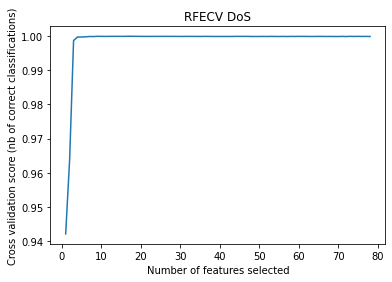

In [67]:
print(__doc__)

import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv_DoS = RFECV(estimator=clf_DoS, step=1, cv=10, scoring='accuracy')
rfecv_DoS.fit(X_DoS_test, Y_DoS_test)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFECV DoS')
plt.plot(range(1, len(rfecv_DoS.grid_scores_) + 1), rfecv_DoS.grid_scores_)
plt.show()

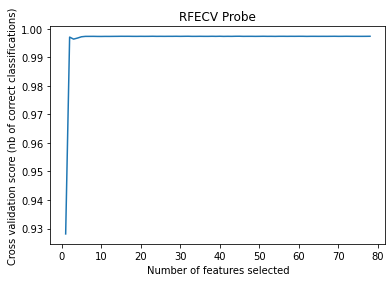

In [68]:
rfecv_Probe = RFECV(estimator=clf_Probe, step=1, cv=10, scoring='accuracy')
rfecv_Probe.fit(X_Probe_test, Y_Probe_test)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFECV Probe')
plt.plot(range(1, len(rfecv_Probe.grid_scores_) + 1), rfecv_Probe.grid_scores_)
plt.show()

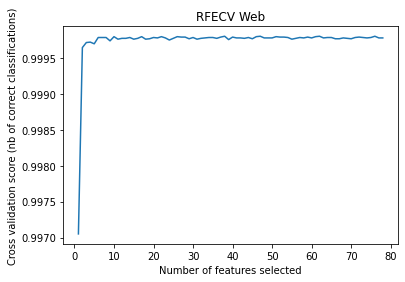

In [70]:
rfecv_Web = RFECV(estimator=clf_Web, step=1, cv=10, scoring='accuracy')
rfecv_Web.fit(X_Web_test, Y_Web_test)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFECV Web')
plt.plot(range(1, len(rfecv_Web.grid_scores_) + 1), rfecv_Web.grid_scores_)
plt.show()

C:\Users\Mathis\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


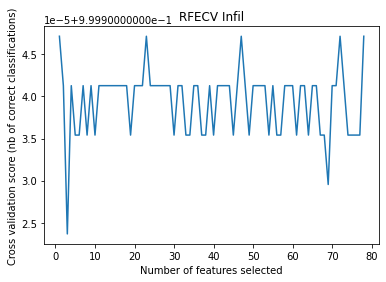

In [71]:
rfecv_Infil = RFECV(estimator=clf_Infil, step=1, cv=10, scoring='accuracy')
rfecv_Infil.fit(X_Infil_test, Y_Infil_test)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFECV Infil')
plt.plot(range(1, len(rfecv_Infil.grid_scores_) + 1), rfecv_Infil.grid_scores_)
plt.show()

# Using 13 Features for each category

# Confusion Matrices
## DoS

In [73]:
# reduce test dataset to 13 features, use only features described in rfecolname_DoS etc.
X_DoS_test2=X_DoS_test[:,rfecolindex_DoS]
X_Probe_test2=X_Probe_test[:,rfecolindex_Probe]
X_Web_test2=X_Web_test[:,rfecolindex_Web]
X_Infil_test2=X_Infil_test[:,rfecolindex_Infil]
X_Infil_test2.shape

(170313, 13)

In [74]:
Y_DoS_pred2=clf_rfeDoS.predict(X_DoS_test2)
# Create confusion matrix
pd.crosstab(Y_DoS_test, Y_DoS_pred2, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,1
Actual attacks,,
0,170190,114
1,51,31951


## Probe

In [75]:
Y_Probe_pred2=clf_rfeProbe.predict(X_Probe_test2)
# Create confusion matrix
pd.crosstab(Y_Probe_test, Y_Probe_pred2, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,2
Actual attacks,,
0,167011,3293
2,1350,38395


## Web

In [76]:
Y_Web_pred2=clf_rfeWeb.predict(X_Web_test2)
# Create confusion matrix
pd.crosstab(Y_Web_test, Y_Web_pred2, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,3
Actual attacks,,
0,170290,14
3,528,21


## Infil

In [77]:
Y_Infil_pred2=clf_rfeInfil.predict(X_Infil_test2)
# Create confusion matrix
pd.crosstab(Y_Infil_test, Y_Infil_pred2, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks,0,4
Actual attacks,,
0,170274,30
4,5,4


# Cross Validation: Accuracy, Precision, Recall, F-measure

## DoS

In [78]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=10, scoring='f1')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99990 (+/- 0.00016)
Precision: 0.99956 (+/- 0.00080)
Recall: 0.99978 (+/- 0.00049)
F-measure: 0.99967 (+/- 0.00049)


## Probe

In [79]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99738 (+/- 0.00077)
Precision: 0.99584 (+/- 0.00145)
Recall: 0.99563 (+/- 0.00157)
F-measure: 0.99573 (+/- 0.00126)


## Web

In [80]:
accuracy = cross_val_score(clf_rfeWeb, X_Web_test2, Y_Web_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_rfeWeb, X_Web_test2, Y_Web_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_rfeWeb, X_Web_test2, Y_Web_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_rfeWeb, X_Web_test2, Y_Web_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99982 (+/- 0.00016)
Precision: 0.98762 (+/- 0.02349)
Recall: 0.98535 (+/- 0.02486)
F-measure: 0.98625 (+/- 0.01235)


## Infil

In [81]:
accuracy = cross_val_score(clf_rfeInfil, X_Infil_test2, Y_Infil_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_rfeInfil, X_Infil_test2, Y_Infil_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_rfeInfil, X_Infil_test2, Y_Infil_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_rfeInfil, X_Infil_test2, Y_Infil_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

C:\Users\Mathis\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Accuracy: 0.99995 (+/- 0.00008)


C:\Users\Mathis\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Mathis\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mathis\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.72499 (+/- 0.41536)


C:\Users\Mathis\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Recall: 0.79999 (+/- 0.48990)


C:\Users\Mathis\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


F-measure: 0.74999 (+/- 0.42819)


# Stratified CV => Stays the same

In [82]:
from sklearn.model_selection import StratifiedKFold
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=StratifiedKFold(10), scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99990 (+/- 0.00016)


In [83]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=StratifiedKFold(10), scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99738 (+/- 0.00077)


In [84]:
accuracy = cross_val_score(clf_rfeWeb, X_Web_test2, Y_Web_test, cv=StratifiedKFold(10), scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99982 (+/- 0.00016)


In [85]:
accuracy = cross_val_score(clf_rfeInfil, X_Infil_test2, Y_Infil_test, cv=StratifiedKFold(10), scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

C:\Users\Mathis\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Accuracy: 0.99995 (+/- 0.00008)


# CV 2, 5, 10, 30, 50 fold

## DoS

In [86]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=2, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99980 (+/- 0.00004)


In [87]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=5, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99986 (+/- 0.00010)


In [88]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99990 (+/- 0.00016)


In [89]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=30, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99989 (+/- 0.00026)


In [90]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=50, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99989 (+/- 0.00032)


## Probe

In [91]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=2, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99723 (+/- 0.00000)


In [92]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=5, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99733 (+/- 0.00040)


In [93]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99738 (+/- 0.00077)


In [94]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=30, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99735 (+/- 0.00131)


In [95]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=50, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99731 (+/- 0.00152)


## Web

In [96]:
accuracy = cross_val_score(clf_rfeWeb, X_Web_test2, Y_Web_test, cv=2, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99982 (+/- 0.00007)


In [97]:
accuracy = cross_val_score(clf_rfeWeb, X_Web_test2, Y_Web_test, cv=5, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99978 (+/- 0.00007)


In [98]:
accuracy = cross_val_score(clf_rfeWeb, X_Web_test2, Y_Web_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99982 (+/- 0.00016)


In [99]:
accuracy = cross_val_score(clf_rfeWeb, X_Web_test2, Y_Web_test, cv=30, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99982 (+/- 0.00038)


In [100]:
accuracy = cross_val_score(clf_rfeWeb, X_Web_test2, Y_Web_test, cv=50, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99982 (+/- 0.00048)


## Infil

In [101]:
accuracy = cross_val_score(clf_rfeInfil, X_Infil_test2, Y_Infil_test, cv=2, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99995 (+/- 0.00001)


In [102]:
accuracy = cross_val_score(clf_rfeInfil, X_Infil_test2, Y_Infil_test, cv=5, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99994 (+/- 0.00006)


In [103]:
accuracy = cross_val_score(clf_rfeInfil, X_Infil_test2, Y_Infil_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

C:\Users\Mathis\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Accuracy: 0.99995 (+/- 0.00008)


In [104]:
accuracy = cross_val_score(clf_rfeInfil, X_Infil_test2, Y_Infil_test, cv=30, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

C:\Users\Mathis\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=30.
  warnings.warn(("The least populated class in y has only %d"


Accuracy: 0.99995 (+/- 0.00019)


In [105]:
accuracy = cross_val_score(clf_rfeInfil, X_Infil_test2, Y_Infil_test, cv=50, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

C:\Users\Mathis\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=50.
  warnings.warn(("The least populated class in y has only %d"


Accuracy: 0.99995 (+/- 0.00025)
